### **Warning : this notebook will be run slow and take a lot of memory**

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4

# How to animate all ghosts with $\theta_x$ and $\theta_y$ ?

In [4]:
import batoid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import sys
from IPython.display import HTML
from collections import defaultdict

In [5]:
# Loading LSST geometry
# Also, you can change the filter (replace the g by i, r, u, y or z, for others see the batoid documentation)
telescope = batoid.Optic.fromYaml("LSST_g.yaml")

for surface in telescope.itemDict.values():
    if isinstance(surface, batoid.RefractiveInterface):
        surface.forwardCoating = batoid.SimpleCoating(0.02, 0.98)
        surface.reverseCoating = batoid.SimpleCoating(0.02, 0.98)
    if isinstance(surface, batoid.Detector):
        surface.forwardCoating = batoid.SimpleCoating(0.30, 0.70)

In [6]:
# Initialise theta_x and theta_y as you want
theta_x = np.array([0])
theta_y = np.linspace(0, 2, 10)

In [7]:
# Initialise some variable to stock the data
progress, keep_steps = 0, 0
total_steps = len(theta_x)*len(theta_y)

data_list = []

In [8]:
# Start the calculus
for tx in theta_x:
    for ty in theta_y:
        
        progress += 1
    
        rays = batoid.RayVector.asPolar(
            telescope, wavelength=620e-9,
            theta_x=np.deg2rad(tx), theta_y=np.deg2rad(ty),
            naz=1000, nrad=300, flux=1.0
        )
        rForward, rReverse = telescope.traceSplit(rays, minFlux=1e-4)
    
        sys.stdout.write(f"\rProgress: {progress / total_steps * 100:.2f} %")
        sys.stdout.flush()
    
        if len(rForward) == 0:
            continue
    
        keep_steps += 1

        # Stock useful data
        for i, rr in enumerate(rForward[:]):
            data_list.append({
                "theta_x": tx,
                "theta_y": ty,
                "x_data": rr.x.tolist(),
                "y_data": rr.y.tolist(),
                "path": rr.path
            })
    
print(f"\n{keep_steps} / {total_steps} simulations keep")

Progress: 100.00 %
10 / 10 simulations keep


In [9]:
# Reorganisation of the data and clear data_list

# New dictionnary to regroupe data within (theta_x, theta_y)
grouped_data = defaultdict(lambda: {"x_data": [], "y_data": [], "path": []})

# Merge data
for item in data_list:
    key = (item["theta_x"], item["theta_y"])
    grouped_data[key]["x_data"].extend(item["x_data"])
    grouped_data[key]["y_data"].extend(item["y_data"])
    grouped_data[key]["path"].extend(item["path"])

data_list.clear()

# Data's separation
theta_x, theta_y = zip(*grouped_data.keys()) if grouped_data else ([], [])
x_data = [grouped_data[key]["x_data"] for key in grouped_data.keys()]
y_data = [grouped_data[key]["y_data"] for key in grouped_data.keys()]
path = [grouped_data[key]["path"] for key in grouped_data.keys()]

grouped_data.clear()

In [10]:
# Animation function
def update_ghost(frame):
    # Delete old hexbin
    if hexbin_collection[0] is not None:
        hexbin_collection[0].remove()

    # Average's calculus
    mean_x = np.mean(x_data[frame])
    mean_y = np.mean(y_data[frame])

    # Add new hexbin
    hexbin_collection[0] = ax.hexbin(x_data[frame], y_data[frame], extent=[-0.35, 0.35, -0.35, 0.35], gridsize=500, norm=colors.AsinhNorm())
    marker.set_data([mean_x], [mean_y])
    ax.set_title(f"Ray Tracing (color normalize with asinh function) - θx: {theta_x[frame]:.2f}°, θy: {theta_y[frame]:.2f}°")

    # Stock hexbin's data
    counts = hexbin_collection[0].get_array()
    verts = hexbin_collection[0].get_offsets()

    # Bin's selection on average's axes
    bins_x = verts[:, 0][np.isclose(verts[:, 1], mean_y, atol=0.02)]
    counts_x = counts[np.isclose(verts[:, 1], mean_y, atol=0.02)]
    
    bins_y = verts[:, 1][np.isclose(verts[:, 0], mean_x, atol=0.02)]
    counts_y = counts[np.isclose(verts[:, 0], mean_x, atol=0.02)]

    # See the progress
    sys.stdout.write(f"\rProgress: {(frame+1) / keep_steps * 100:.2f} %")
    sys.stdout.flush()

    # Stock useful data
    data_list.append({
            "theta_x": theta_x[frame],
            "theta_y": theta_y[frame],
            "x_bins": bins_x,
            "x_counts": counts_x,
            "y_bins": bins_y,
            "y_counts": counts_y,
            "paths": path[frame]
        })
    
    return marker,

Progress: 100.00 %

Progress: 10.00 %

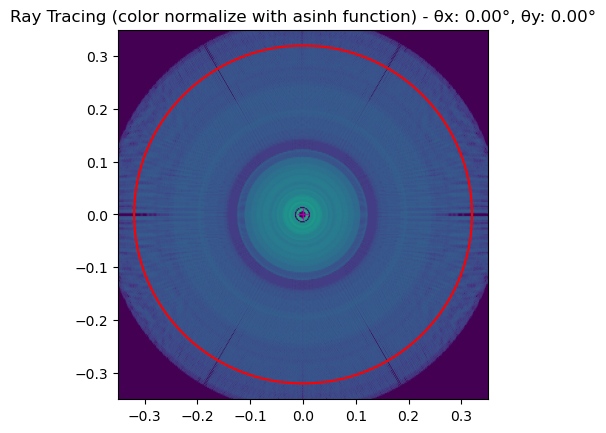

In [11]:
# Stock hexbin for update
hexbin_collection = [None]

# Initialise plot
fig, ax = plt.subplots()
th = np.linspace(0, 2*np.pi, 1000)
ax.plot(0.32*np.cos(th), 0.32*np.sin(th), c='r', label="Cercle optique")
marker, = ax.plot([], [], marker='+', color='m', linestyle='None', markersize=8, alpha=0.8, label="Centre")

ax.set_xlim(-0.35, 0.35)
ax.set_ylim(-0.35, 0.35)
ax.set_aspect("equal")

# Generate animation
ani = animation.FuncAnimation(fig, update_ghost, frames=keep_steps, interval=500, blit=False)

# Plot Jupyter
HTML(ani.to_jshtml())  # Alternative : HTML(ani.to_html5_video())

# How to have an animate histogram from this first animation ?

In [39]:
# Take the maximum to freeze y axe
xmax = np.max([np.max(item["x_counts"]) for item in data_list])
ymax = np.max([np.max(item["y_counts"]) for item in data_list])

239942.0 240122.0


In [53]:
# Animation function
def update_hist(frame):
    # Delete old histogram
    ax[0].clear()
    ax[1].clear()
    
    #Plot new histogram
    ax[0].bar(data_list[frame]["x_bins"], data_list[frame]["x_counts"], width=0.005, color='blue')
    ax[0].set_yscale('log')
    ax[0].set_xlabel("x (aligned to average y)")
    ax[0].set_ylabel("Number of rays (log scale)")
    ax[0].set_ylim([1, xmax*1.1])
    
    ax[1].bar(data_list[frame]["y_bins"], data_list[frame]["y_counts"], width=0.005, color='green')
    ax[1].set_yscale('log')
    ax[1].set_xlabel("y (aligned to average x)")
    ax[1].set_ylabel("Number of rays (log scale)")
    ax[1].set_ylim([1, ymax*1.1])

    sys.stdout.write(f"\rProgress: {(frame+1) / keep_steps * 100:.2f} %")
    sys.stdout.flush()

    plt.title(f"Histograms on average's axes - theta_x: {data_list[frame]['theta_x']:.2f}°, theta_y: {data_list[frame]['theta_y']:.2f}°")
    plt.tight_layout()

Progress: 100.00 %

Progress: 10.00 %

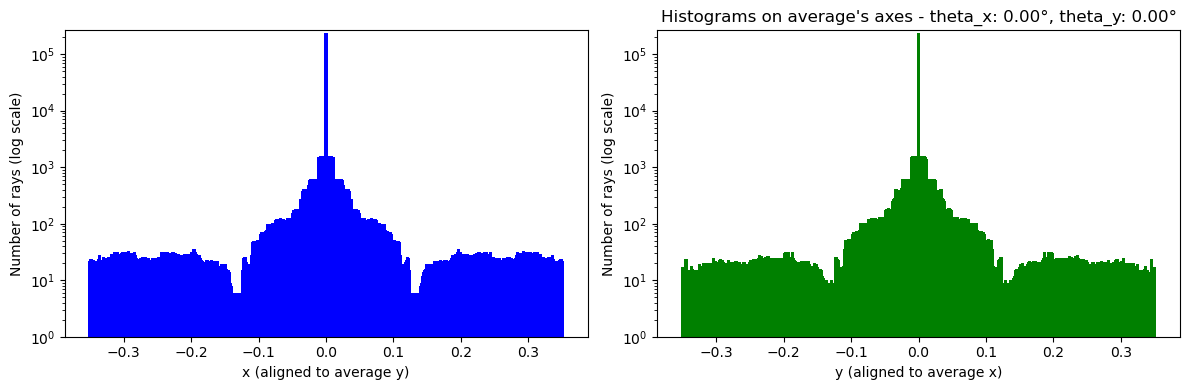

In [55]:
# Initialise plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Generate animation
ani = animation.FuncAnimation(fig, update_hist, frames=keep_steps, interval=500, blit=False)

# Plot Jupyter
HTML(ani.to_jshtml())  # Alternative : HTML(ani.to_html5_video())

# Observations

## 1. Animation des ghosts :
 - On remarque que les ghosts ne se déplace pas en "bloc" mais que chacun a sa propre vitesse. Ceci même à des influctuation de densité (nombre de photons par hexbin) dont on parlera en partie 2.
 - Si l'on se concentre dans le cas $\theta_x = \theta_y = 0$, on peut voir des zones où il semble y avoir une sous densité sur l'extérieur (autour du cercle rouge) des ghosts. A ce que j'ai pu voir rapidement, on n'obtient pas les mêmes densités sur l'extérieur en fonction de l'angle (par exemple les couples ($\theta_x = 2$°, $\theta_y = 0$°) et ($\theta_x = 0$°, $\theta_y = 2$°) donne les mêmes résultats tourner d'un angle $\frac{\pi}{2}$ mais ne donnera pas le même schéma si l'angle est tourné de $\frac{\pi}{4}$.
 - **(Refaire une simu sur un autre notebook pour appuyer mes propos)**
## 2. Animation des histogrammes :
 - Dans le cas $\theta_x = \theta_y = 0$, on peut voir de très légère différence mais on a globalement le même profil de densité.
 - Ensuite, au fur et à mesure que $\theta_y$ augmente, on remarque que le profil sur l'axe des x s'éffondre au centre et se resserre vers le centre. Quant à l'axe des y, le pic fluctue par moment mais reste largement dominant tout en se déplaçant vers des y plus élevés. En dehors du pic, cela reste flou si l'on regarde uniquement les histogrammes mais il semble que les ghosts les plus faibles se sépare en lançant place à des zones "vides" ou très faiblement atteinte par les rayons.